# Probability Density Functions

In the previous chapter, we modeled data with theoretical distributions including the binomial, Poisson, exponential, and normal distributions.

The binomial and Poisson distributions are discrete, which means that the outcomes have to be distinct or separate elements, like an integer number of hits and misses, or goals scored. In a discrete distribution, each outcome is associated with a probability mass.

The exponential and normal distribution are **continuous**, which means the outcomes can be at any point in a range of possible values. In a continuous distribution, each outcome is associated with a probability density. Probability density is an abstract idea, and many people find it difficult at first, but we’ll take it one step at a time. As a first step, let’s think again about comparing distributions.

https://allendowney.github.io/ThinkStats/chap06.html


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statadict

from thinkstats import decorate, poisson_pmf, two_bar_plots, two_cdf_plots, make_normal_model, exponential_cdf, download
from empiricaldist import Pmf, Cdf
from scipy.stats import trimboth, norm

## Comparing Distributions

In the previous chapter, when we compared discrete distributions, we used a bar plot to show their probability mass functions (PMFs). When we compared continuous distributions, we used a line plot to show their cumulative distribution functions (CDFs).

For the discrete distributions, we could also have used CDFs. For example, here’s the PMF of a Poisson distribution with lam=2.2, which is a good model for the distribution of household size in the NSFG data.

The following cells download the data files and install statadict, which we need to read the data.


In [2]:
from nsfg import read_fem_resp
resp = read_fem_resp()

In [3]:
older = resp.query("age >= 25")
num_family = older["numfmhh"]

In [4]:
pmf_family = Pmf.from_seq(num_family, name="data")

In [5]:
lam = 2.2
ks = np.arange(11)
ps = poisson_pmf(ks, lam)

pmf_poisson = Pmf(ps, ks, name="Poisson model")

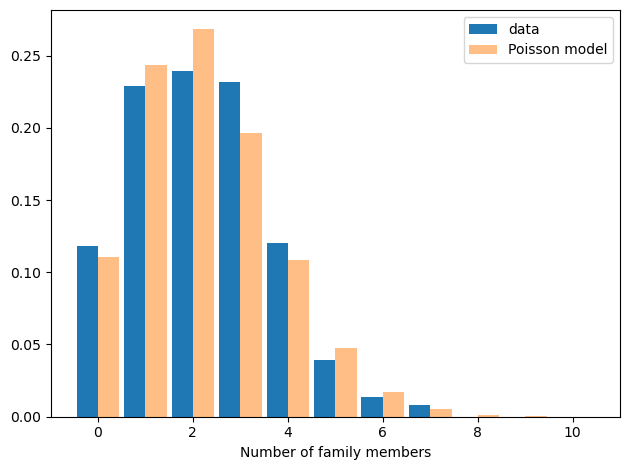

In [6]:
two_bar_plots(pmf_family, pmf_poisson)
decorate(xlabel="Number of family members")

In [7]:
cdf_family = pmf_family.make_cdf()
cdf_poisson = pmf_poisson.make_cdf()

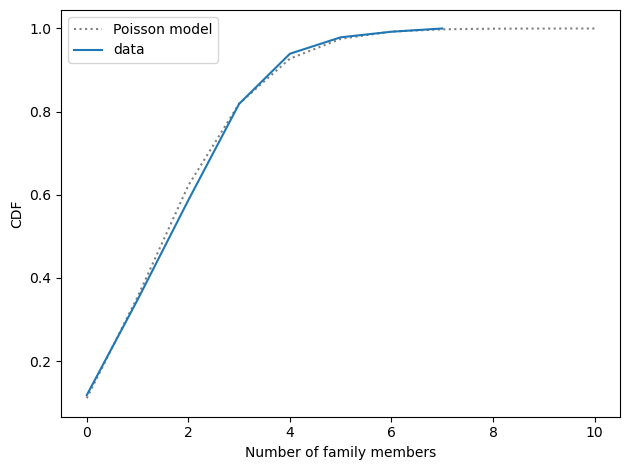

In [8]:
two_cdf_plots(cdf_poisson, cdf_family)
decorate(xlabel="Number of family members")

When we compare CDFs, the deviations are less prominent, but we can see where and how the distributions differ. PMFs tend to emphasize small differences – sometimes CDFs provide a better sense of the big picture.

CDFs also work well with continuous data. As an example, let’s look at the distribution of birth weights again, which is in the NSFG pregnancy file.

In [9]:
from nsfg import read_fem_preg

preg = read_fem_preg()
birth_weights = preg["totalwgt_lb"].dropna()

In [10]:
trimmed = trimboth(birth_weights, 0.01)
cdf_model = make_normal_model(trimmed)

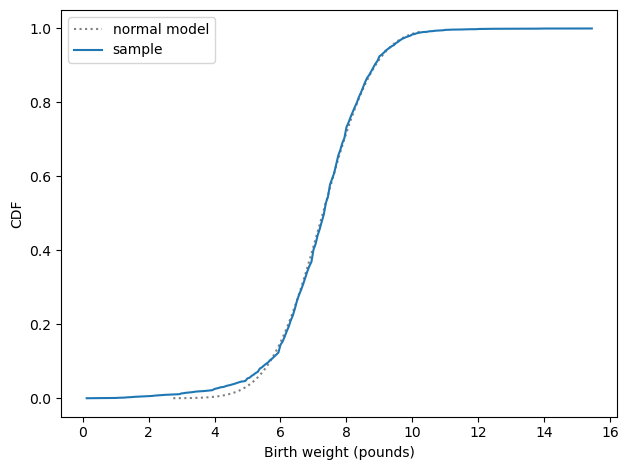

In [11]:
cdf_birth_weight = Cdf.from_seq(birth_weights, name="sample")
two_cdf_plots(cdf_model, cdf_birth_weight, xlabel="Birth weight (pounds)")

## Probability Density

We’ll start with the probability density function (PDF) of the normal distribution, which computes the density for the quantities, xs, given mu and sigma.

In [12]:
def normal_pdf(xs, mu, sigma):
    """Evaluates the normal probability density function."""
    z = (xs - mu) / sigma
    return np.exp(-(z**2) / 2) / sigma / np.sqrt(2 * np.pi)

In [13]:
#For mu and sigma we’ll use the mean and standard deviation of the trimmed birth weights.

m, s = np.mean(trimmed), np.std(trimmed)

In [14]:
low = m - 4 * s
high = m + 4 * s
qs = np.linspace(low, high, 201)
ps = normal_pdf(qs, m, s)

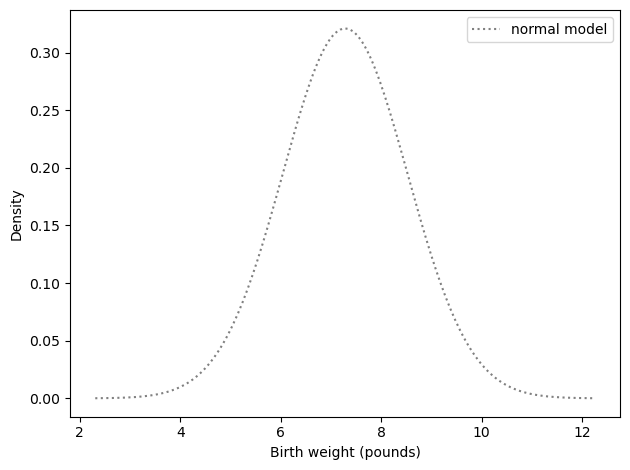

In [15]:
plt.plot(qs, ps, label="normal model", ls=":", color="gray")
decorate(xlabel="Birth weight (pounds)", ylabel="Density")

In [16]:
normal_pdf(m, m, s)

0.32093416297880123

By itself, a probability density doesn’t mean much – most importantly, **it is not a probability**. It would be incorrect to say that the probability is 32% that a randomly-chosen birth weight equals m. In fact, the probability that a birth weight is truly, exactly, and precisely equal to m – or any other specific value – is zero.

However, we can use the probability densities to compute the probability that an outcome falls in an **interval between two values**, by computing the **area under the curve**.

We could do that with the normal_pdf function, but it is more convenient to use the ```NormalPdf``` class, which is defined in the thinkstats module. Here’s how we create a ```NormalPdf``` object with the same mean and standard deviation as the birth weights in the NSFG dataset.

In [17]:
from thinkstats import NormalPdf

pdf_model = NormalPdf(m, s, name="normal model")
pdf_model

NormalPdf(7.280883100022579, 1.2430657948614345, name='normal model')

In [18]:
pdf_model(m)

0.32093416297880123

Now, to compute the area under the PDF, we can use the following function, which takes a NormalPdf object and the bounds of an interval, ```low``` and ```high```. It evaluates the normal PDF at equally-spaced quantities between low and high, and uses the SciPy function ```simpson``` to ```estimate the area under the curve``` (simpson is so named because it uses an algorithm called Simpson’s method).

In [19]:
from scipy.integrate import simpson

def area_under(pdf, low, high):
    qs = np.linspace(low, high, 501)
    ps = pdf(qs)
    return simpson(y=ps, x=qs)

In [20]:
area_under(pdf_model, 2, 12)

0.9999158086616793

In [21]:
# Fraction of birth weights less then or equal to 8.5 pounds
area_under(pdf_model, 0, 8.5)

0.8366380335513807

In [22]:
# Same
norm.cdf(8.5, m, s)

0.8366380358092718

In [23]:
# Birth weights between 6 and 8
area_under(pdf_model, 6, 8)

0.5671317752927691

In [24]:
# Or Same
norm.cdf(8, m, s) - norm.cdf(6, m, s)

0.5671317752921801

So the CDF is the area under the curve of the PDF. If you know calculus, another way to say the same thing is that the CDF is the integral of the PDF. And conversely, the PDF is the derivative of the CDF.

## The Exponential PDF

To get your head around probability density, it might help to see another example. In the previous chapter, we used an exponential distribution to model the time until the first goal in a hockey game. We used the following function to compute the exponential CDF, where lam is the rate in goals per unit of time.

In [25]:
from thinkstats import ExponentialPdf

lam = 6
pdf_expo = ExponentialPdf(lam, name="exponential model")
pdf_expo

ExponentialPdf(6, name='exponential model')

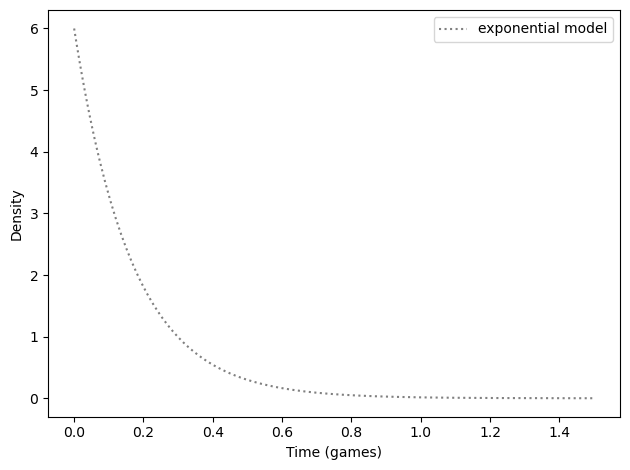

In [26]:
qs = np.linspace(0, 1.5, 201)
pdf_expo.plot(qs, ls=":", color="gray")
decorate(xlabel="Time (games)", ylabel="Density")

Looking at the y-axis, you might notice that some of these densities are greater than 1, which is a reminder that a probability density is not a probability. But the area under a density curve is a probability, so it should never be greater than 1.

If we compute the area under this curve from 0 to 1.5 games, we can confirm that the result is close to 1.

In [27]:
area_under(pdf_expo, 0, 1.5)

0.999876590779019

In [28]:
# If we extend the interval much farther, the result is slightly greater than 1, but that’s because we’re approximating the area numerically. Mathematically, it is exactly 1, as we can confirm using the exponential CDF.
exponential_cdf(7, lam)

1.0

In [29]:
area_under(pdf_expo, 0, 1 / 60)

0.09516258196404043

In [30]:
exponential_cdf(1 / 60, lam)

0.09516258196404048

In summary, if we evaluate a PDF, the result is a probability density – which is not a probability. However, if we compute the area under the PDF, the result is the probability that a quantity falls in an interval. Or we can find the same probability by evaluating the CDF at the beginning and end of the interval and computing the difference.

## Comparing PMFs and PDFs

It is a **common error** to compare the PMF of a sample with the PDF of a theoretical model. For example, suppose we want to compare the distribution of birth weights to a normal model. Here’s a Pmf that represents the distribution of the data.

In [31]:
pmf_birth_weight = Pmf.from_seq(birth_weights, name="data")

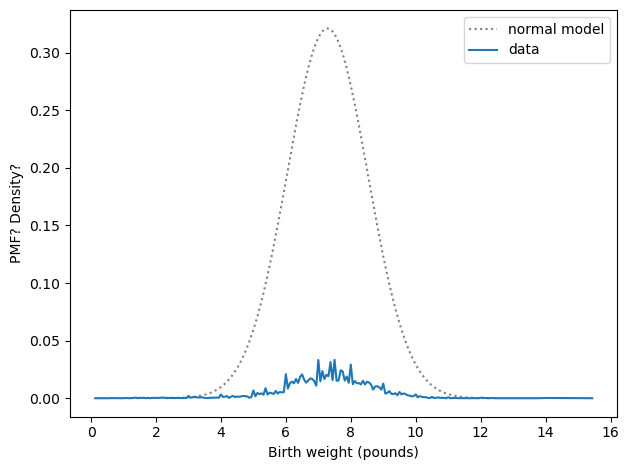

In [32]:
pdf_model.plot(ls=":", color="gray")
pmf_birth_weight.plot()

decorate(xlabel="Birth weight (pounds)", ylabel="PMF? Density?")

It doesn’t work very well. One reason is that they are not in the same units. A PMF contains probability masses and a PDF contains probability densities, so we can’t compare them, and we shouldn’t plot them on the same axes.

As a first attempt to solve the problem, we can make a Pmf that approximates the normal distribution by evaluating the PDF at a discrete set of points. NormalPdf provides a make_pmf method that does that.

In [33]:
pmf_model = pdf_model.make_pmf()

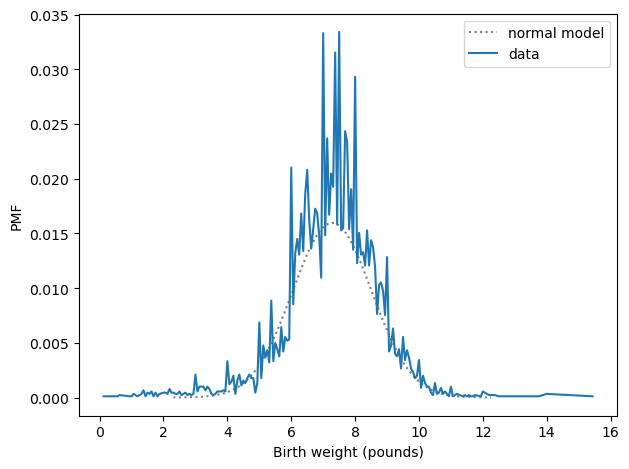

In [34]:
pmf_model.plot(ls=":", color="gray")
pmf_birth_weight.plot()

decorate(xlabel="Birth weight (pounds)", ylabel="PMF")

But this is still not a good way to compare distributions. One problem is that the two Pmf objects contain different numbers of quantities, and the quantities in pmf_birth_weight are not equally spaced, so the probability masses are not really comparable.

## Kernel Density Estimation

Instead of using the model to make a PMF, we can use the data to make a PDF. To show how that works, I’ll start with a small sample of the data.


In [35]:
# Set the random seed so we get the same results every time
np.random.seed(3)

In [36]:
n = 10
sample = birth_weights.sample(n)

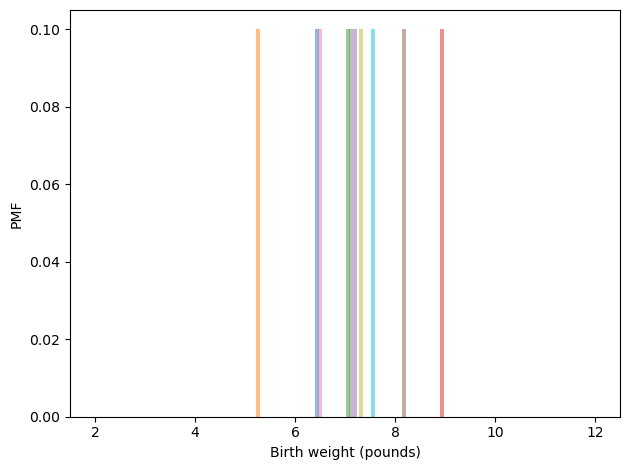

In [37]:
for weight in sample:
    pmf = Pmf.from_seq([weight]) / n
    pmf.bar(width=0.08, alpha=0.5)

xlim = [1.5, 12.5]
decorate(xlabel="Birth weight (pounds)", ylabel="PMF", xlim=xlim)

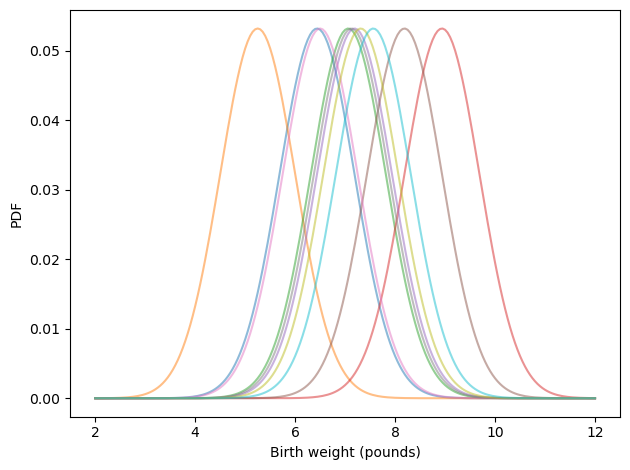

In [38]:
# We can represent that possibility by replacing each discrete probability mass with a continuous probability density, like this.
qs = np.linspace(2, 12, 201)

for weight in sample:
    ps = NormalPdf(weight, 0.75)(qs) / n
    plt.plot(qs, ps, alpha=0.5)

decorate(xlabel="Birth weight (pounds)", ylabel="PDF", xlim=xlim)

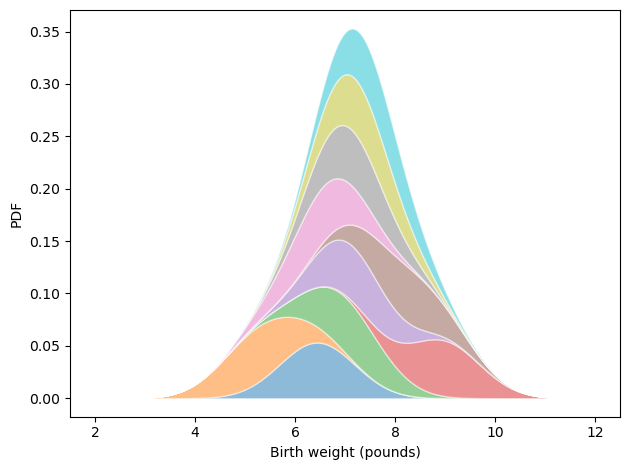

In [39]:
low_ps = np.zeros_like(qs)

for weight in sample:
    ps = NormalPdf(weight, 0.75)(qs) / n
    high_ps = low_ps + ps
    plt.fill_between(qs, low_ps, high_ps, alpha=0.5, lw=1, ec="white")
    low_ps = high_ps

decorate(xlabel="Birth weight (pounds)", ylabel="PDF", xlim=xlim)

When we add up the probability densities for each data point, the result is an estimate of the probability density for the whole sample. This process is called kernel density estimation or KDE. In this context, a “kernel” is one of the small density functions we added up. Because the kernels we used are normal distributions – also known as Gaussians – we could say more specifically that we computed a Gaussian KDE.

SciPy provides a function called gaussian_kde that implements this algorithm. Here’s how we can use it to estimate the distribution of birth weights.

In [40]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(birth_weights)

In [41]:
ps = kde(qs)

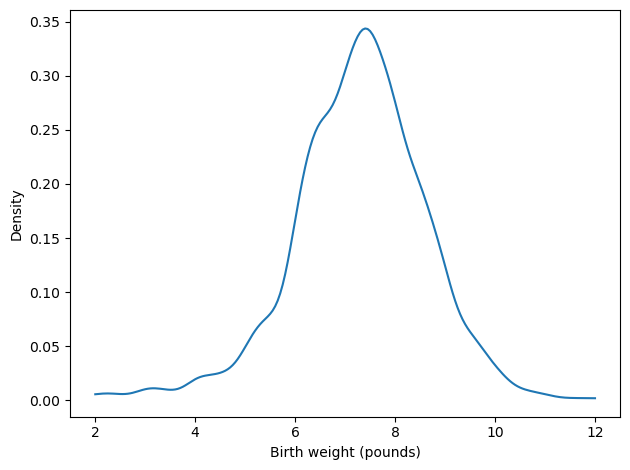

In [42]:
plt.plot(qs, ps)

decorate(xlabel="Birth weight (pounds)", ylabel="Density")

In [43]:
from thinkstats import Pdf

domain = np.min(birth_weights), np.max(birth_weights)
kde_birth_weights = Pdf(kde, domain, name="data")

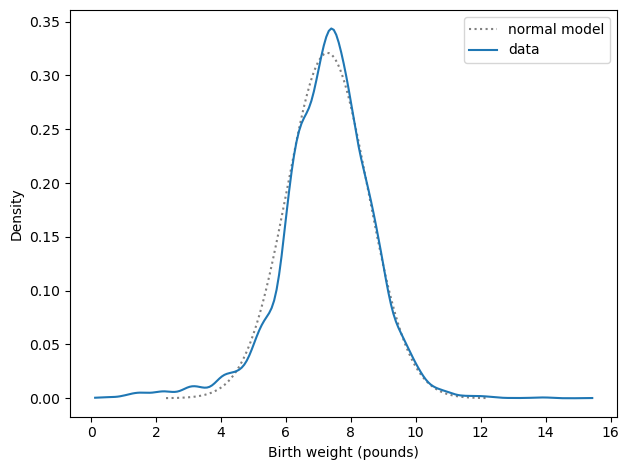

In [44]:
pdf_model.plot(ls=":", color="gray")
kde_birth_weights.plot()

decorate(xlabel="Birth weight (pounds)", ylabel="Density")

Kernel density estimation makes it possible to compare the distribution of a dataset to a theoretical model, and for some audiences, this is a good way to visualize the comparison. But for audiences that are familiar with CDFs, comparing CDFs is often better.

## The Distribution Framework

At this point we have a complete set of ways to represent distributions: PMFs, CDFs, and PDFs The following figure shows these representations and the transitions from one to another. For example, if we have a Pmf, we can use the cumsum function to compute the cumulative sum of the probabilities and get a Cdf that represents the same distribution.


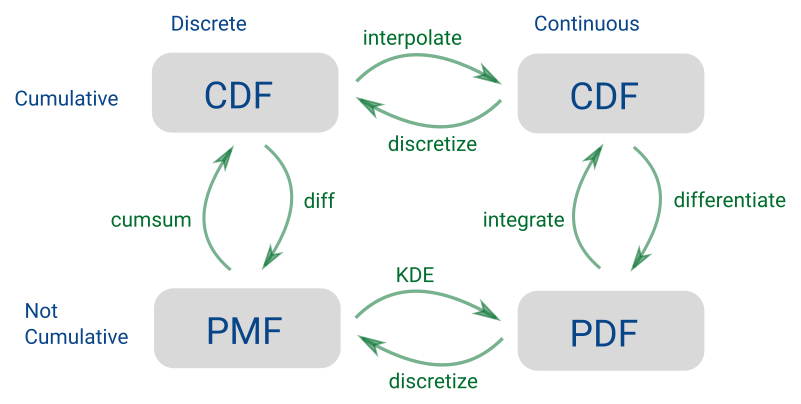

To demonstrate these transitions, we’ll use a new dataset that “contains the time of birth, sex, and birth weight for each of 44 babies born in one 24-hour period at a Brisbane, Australia, hospital,” according to the description. Instructions for downloading the data are in the notebook for this chapter.

According to the information in the file

In [45]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/babyboom.dat", path="datasets/babyboom/")

In [46]:
from thinkstats import read_baby_boom

boom = read_baby_boom()
boom.head()

,time,sex,weight_g,minutes
0,5,1,3837,5
1,104,1,3334,64
2,118,2,3554,78
3,155,2,3838,115
4,257,2,3625,177


In [47]:
diffs = boom["minutes"].diff().dropna()

If births happen with equal probability during any minute of the day, we expect these intervals to follow an exponential distribution. In reality, that assumption is not precisely true, but the exponential distribution might still be a good model for the data.

To find out, we’ll start by making a Pmf that represents the distribution of intervals.

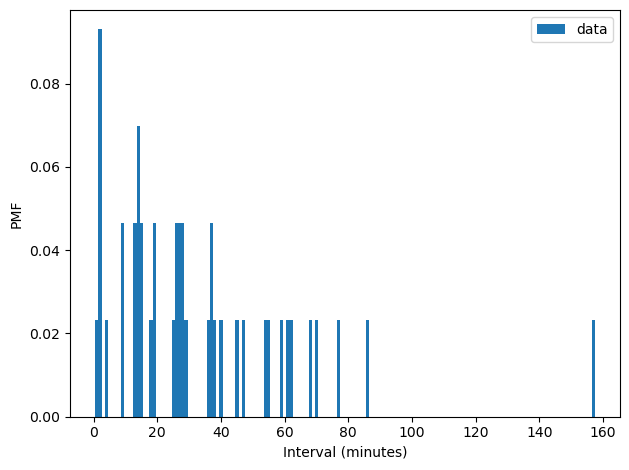

In [48]:
pmf_diffs = Pmf.from_seq(diffs, name="data")
pmf_diffs.bar(width=1)

decorate(xlabel="Interval (minutes)", ylabel="PMF")

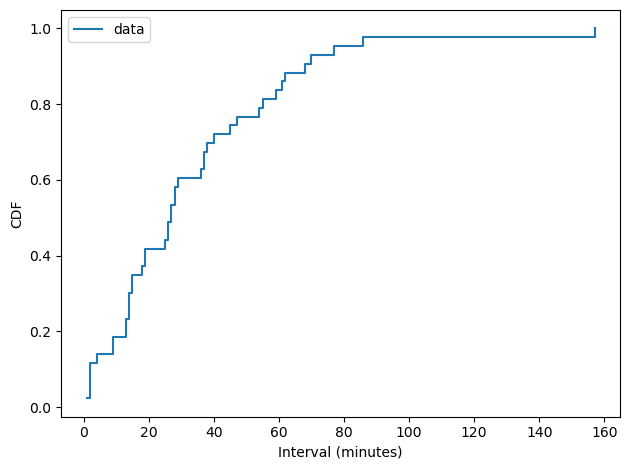

In [49]:
cdf_diffs = pmf_diffs.make_cdf()
cdf_diffs.step()

decorate(xlabel="Interval (minutes)", ylabel="CDF")

The Pmf and Cdf are equivalent in the sense that if we are given either one, we can compute the other. To demonstrate, we’ll use the make_pmf method, which computes the differences between successive probabilities in a Cdf and returns a Pmf.

In [50]:
# The result should be identical to the original Pmf, but there might be small floating-point errors. We can use allclose to check that the result is close to the original Pmf.
pmf_diffs2 = cdf_diffs.make_pmf()

In [51]:
np.allclose(pmf_diffs, pmf_diffs2)

True

From a Pmf, we can estimate a density function by calling gaussian_kde with the probabilities from the Pmf as weights.

In [52]:
kde = gaussian_kde(pmf_diffs.qs, weights=pmf_diffs.ps)

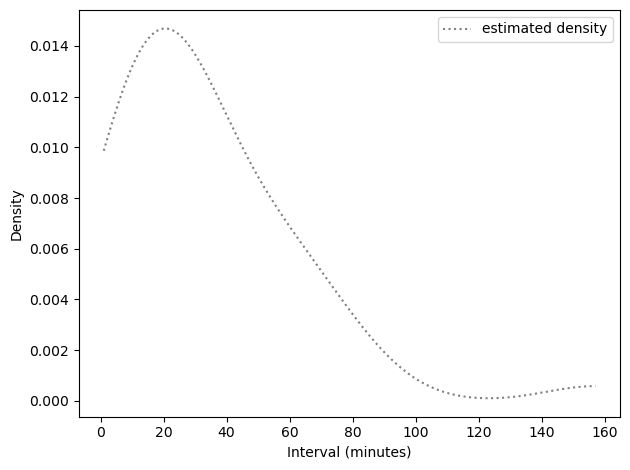

In [53]:
domain = np.min(pmf_diffs.qs), np.max(pmf_diffs.qs)
kde_diffs = Pdf(kde, domain=domain, name="estimated density")

kde_diffs.plot(ls=":", color="gray")
decorate(xlabel="Interval (minutes)", ylabel="Density")

In [54]:
from thinkstats import ExponentialCdf

m = diffs.mean()
lam = 1 / m
cdf_model = ExponentialCdf(lam, name="exponential CDF")

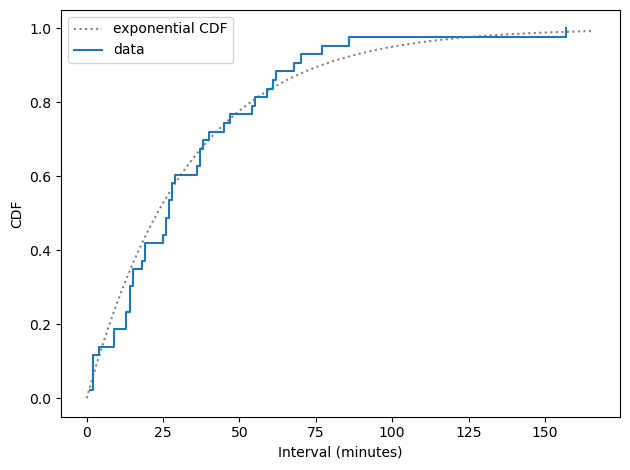

In [55]:
cdf_model.plot(ls=":", color="gray")
cdf_diffs.step()

decorate(xlabel="Interval (minutes)", ylabel="CDF")

Given an ```ExponentialCdf```, we can use ```make_cdf``` to discretize the CDF – that is, to make a discrete approximation by evaluating the CDF at a sequence of equally spaced quantities.



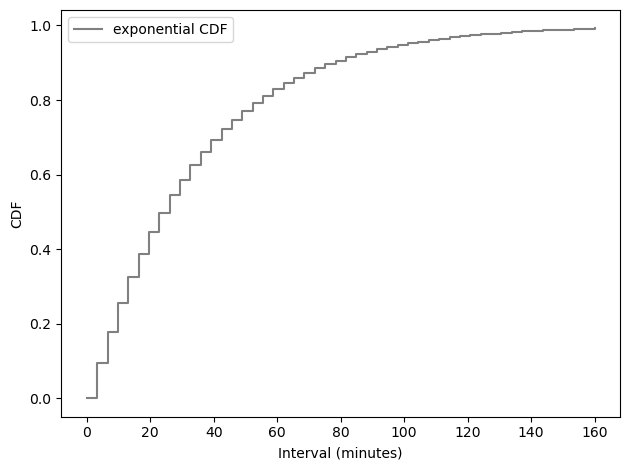

In [56]:
qs = np.linspace(0, 160)
discrete_cdf_model = cdf_model.make_cdf(qs)
discrete_cdf_model.step(color="gray")

decorate(xlabel="Interval (minutes)", ylabel="CDF")

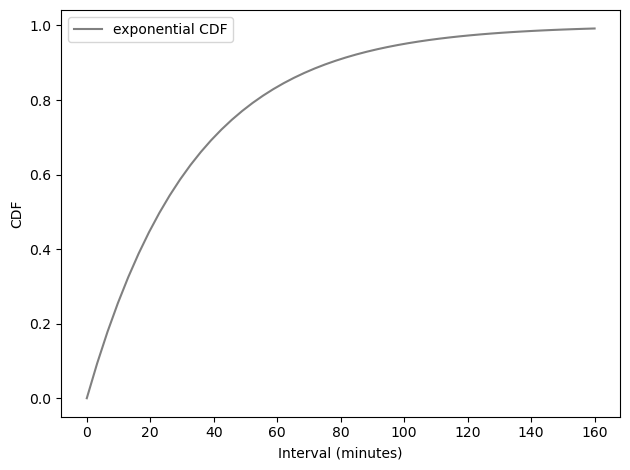

In [57]:
discrete_cdf_model.plot(color="gray")

decorate(xlabel="Interval (minutes)", ylabel="CDF")

In [58]:
import sympy as sp

x = sp.Symbol("x", real=True, positive=True)
λ = sp.Symbol("λ", real=True, positive=True)

cdf = 1 - sp.exp(-λ * x)
cdf

1 - exp(-x*λ)

In [59]:
pdf = sp.diff(cdf, x)
pdf

λ*exp(-x*λ)

In [60]:
sp.integrate(pdf, x)

-exp(-x*λ)

This example shows how we use Pmf, Cdf, and Pdf objects to represent PMFs, CDFs, and PDFs, and demonstrates the process for converting from each to the others.

## Glossary

* continuous: A quantity is continuous if it can have any value in a range on the number line. Most things we measure in the world – like weight, distance, and time – are continuous.

* discrete: A quantity is discrete if it can have a limited set of values, like integers or categories. Exact counts are discrete, as well as categorical variables.

* probability density function (PDF): A function that shows how density (not probability) is spread across the values of a continuous variable. The area under the PDF within an interval gives the probability that the variable falls in that interval range.

* probability density: The value of a PDF at a specific point; it’s not a probability itself, but it can be used to compute a probability.

* kernel density estimation (KDE): A method for estimating a PDF based on a sample.

* discretize: To approximate a continuous quantity by dividing its range into discrete levels or categories.

## Exercise 6.1

In World Cup soccer (football), suppose the time until the **first goal** is well modeled by an exponential distribution with rate ```lam=2.5``` goals per game. Make an ExponentialPdf to represent this distribution and use area_under to compute the probability that the time until the first goal is less than half of a game. Then use an ExponentialCdf to compute the same probability and check that the results are consistent.

Use ExponentialPdf to compute the probability the first goal is scored in the second half of the game. Then use an ExponentialCdf to compute the same probability and check that the results are consistent.


In [61]:
lam = 2.5
lam = 2.5 / 90 # per minute
pdf_goal = ExponentialPdf(lam, name="exponential model")
pdf_goal

ExponentialPdf(0.027777777777777776, name='exponential model')

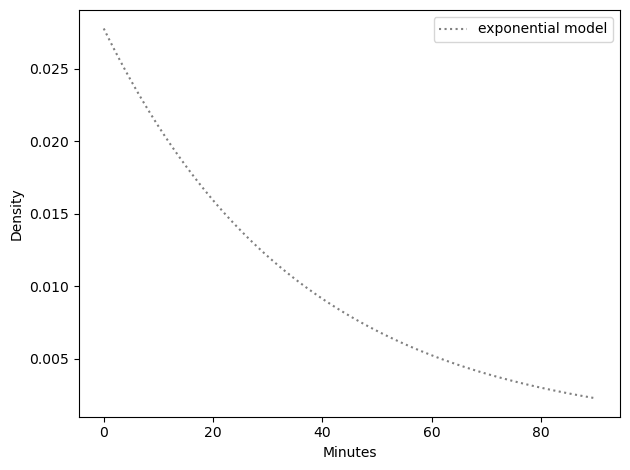

In [62]:
qs = np.linspace(0, 90, 90)
pdf_goal.plot(qs, ls=":", color="gray")
decorate(xlabel="Minutes", ylabel="Density")

In [63]:
area_under(pdf_goal, 0, 45)

0.7134952031399646

In [64]:
cdf_goal = ExponentialCdf(lam, name="exponential CDF")

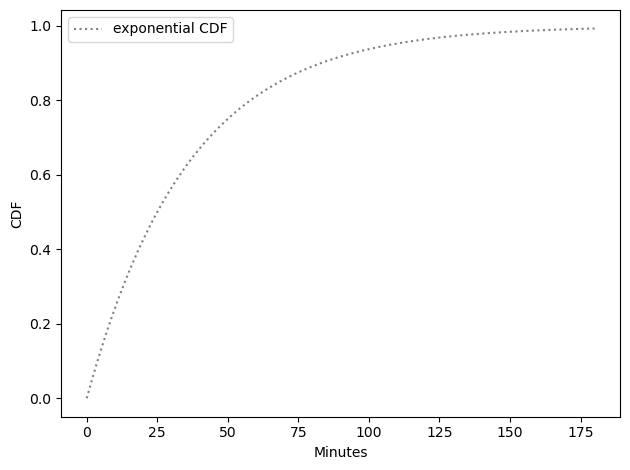

In [65]:
cdf_goal.plot(ls=":", color="gray")

decorate(xlabel="Minutes", ylabel="CDF")

In [66]:
round(area_under(pdf_goal, 0, 45), 4) == round(cdf_goal(45), 4)

True

In [67]:
# Second half of the game

round(area_under(pdf_goal, 45, 90), 4) == round(cdf_goal(90) - cdf_goal(45), 4)

True

## Exercise 6.2

In order to join Blue Man Group, you have to be male between 5’10” and 6’1”, which is roughly 178 to 185 centimeters. Let’s see what fraction of the male adult population in the United States meets this requirement.

The heights of male participants in the BRFSS are well modeled by a normal distribution with mean 178 cm and standard deviation 7 cm.

In [68]:
from thinkstats import read_brfss

brfss = read_brfss()
male = brfss.query("sex == 1")
heights = male["htm3"].dropna()

In [69]:
trimmed = trimboth(heights, 0.01)
m, s = np.mean(trimmed), np.std(trimmed)
m, s

(178.10278947124948, 7.017054887136004)

In [70]:
from thinkstats import NormalCdf

cdf_normal_model = NormalCdf(m, s, name='normal model')

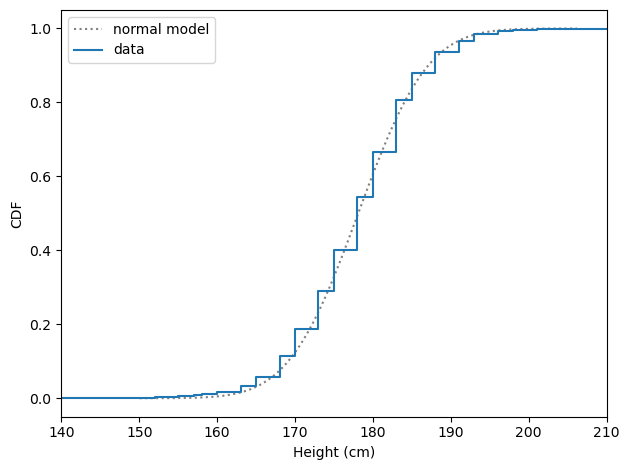

In [71]:
cdf_height = Cdf.from_seq(heights, name="data")
cdf_normal_model.plot(ls=":", color="gray")
cdf_height.step()

xlim = [140, 210]
decorate(xlabel="Height (cm)", ylabel="CDF", xlim=xlim)

Use ```gaussian_kde``` to make a Pdf that approximates the PDF of male height. Hint: Investigate the bw_method argument, which can be used to control the smoothness of the estimated density. Plot the estimated density and compare it to a NormalPdf with mean m and standard deviation s.

Use a NormalPdf and area_under to compute the fraction of people in the normal model that are between 178 and 185 centimeters. Use a NormalCdf to compute the same fraction, and check that the results are consistent. Finally, use the empirical Cdf of the data to see what fraction of people in the dataset are in the same range.

In [74]:
pmf_trimmed = cdf_height.make_pmf()

In [77]:
kde_heights = gaussian_kde(pmf_trimmed.qs, weights=pmf_trimmed.ps)

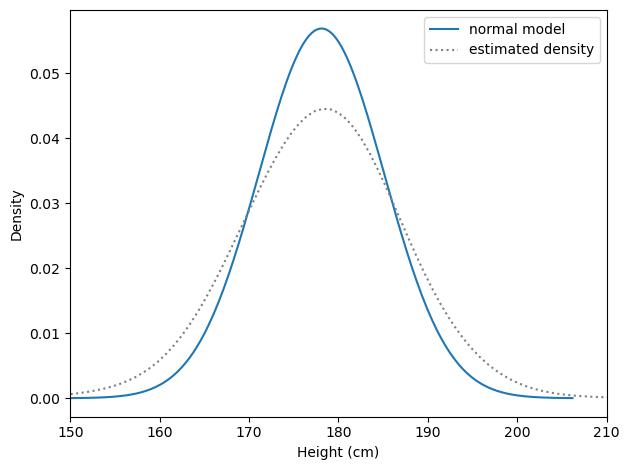

In [89]:
domain = np.min(pmf_trimmed.qs), np.max(pmf_trimmed.qs)
kde_heights_pdf = Pdf(kde_heights, domain=domain, name="estimated density")

normal_pdf = NormalPdf(mu=m, sigma=s, name="normal model")

normal_pdf.plot()
kde_heights_pdf.plot(ls=":", color="gray")
decorate(xlabel="Height (cm)", ylabel="Density", xlim=[150, 210])

In [96]:
area_under(normal_pdf, 178, 185)

0.343020541679175

In [98]:
normal_cdf = NormalCdf(mu=m, sigma=s)

In [100]:
normal_cdf(185) - normal_cdf(178) 

0.34302054167913015

In [102]:
cdf_data = Cdf.from_seq(trimmed)

In [103]:
cdf_data(185) - cdf_data(178)

0.3423165630224889